### Loading the Dataset

In [1]:
from datasets import load_dataset

smt_instr_dataset = load_dataset("ritwik-ghosh/SMT_Fine-tuning_dataset")
smt_instr_dataset


DatasetDict({
    train: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score'],
        num_rows: 639
    })
})

### Visualising Sample-length distribution across the Dataset

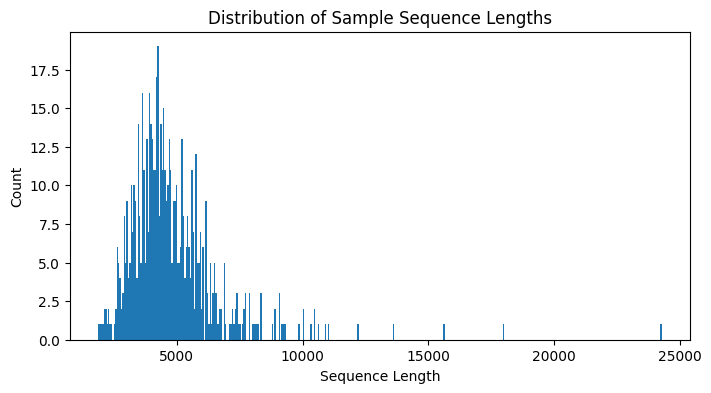

Number of outliers : 32


In [2]:
import matplotlib.pyplot as plt
from datasets import load_dataset

def plot_sequence_lengths(dataset_obj, bin_size):

    # Initializing a list to store the sequence lengths
    sequence_lengths = []

    # list of indices that are too long
    too_long = []

    # Looping over the dataset and to the lengths of text sequences
    for idx, example in enumerate(dataset_obj["train"]):
        sequence_lengths.append(len(example['Context']) + len(example["instruction"]) + len(example["response"]))
        # filters out outliers
        if sequence_lengths[idx] > 8000:
          too_long.append(idx)
    
    # Plotting the histogram
    plt.figure(figsize=(8,4))
    plt.hist(sequence_lengths, bins=bin_size)
    plt.xlabel('Sequence Length')
    plt.ylabel('Count')
    plt.title('Distribution of Sample Sequence Lengths')
    plt.show()

    return too_long
indexes_to_drop = plot_sequence_lengths(smt_instr_dataset, 400)
print(f"Number of outliers : {len(indexes_to_drop)}")

Parameter 'indices'=<generator object <genexpr> at 0x719b74325620> of the transform datasets.arrow_dataset.Dataset.select couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


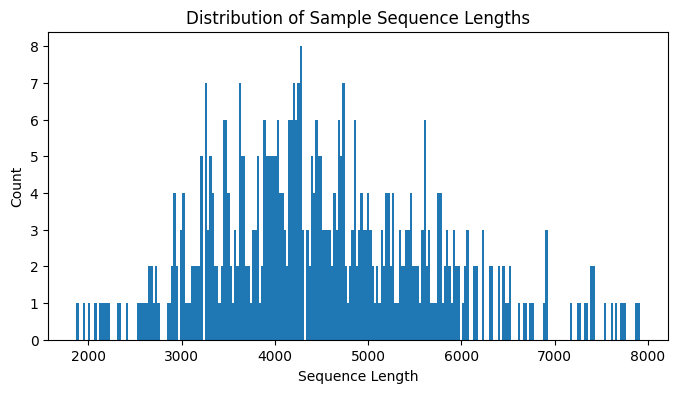

[]

In [3]:
smt_instr_dataset_norm = smt_instr_dataset["train"].select(i for i in range(len(smt_instr_dataset["train"])) if i not in set(indexes_to_drop))
#smt_instr_dataset_norm
smt_instr_dataset_train_test = smt_instr_dataset_norm.train_test_split(test_size=0.2)
plot_sequence_lengths(smt_instr_dataset_train_test, 250)
#smt_instr_dataset_train_test

### Setting the Format of the Instruction-Dataset

In [4]:
def formatting_func(example):
  if example.get("Context", "") != "":
      input_prompt = (f"Below is an instruction that describes a task, paired with an input that provides further context."
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Input: \n"
      f"{example['Context']}\n\n"
      f"### Response: \n"
      f"{example['response']}")

  else:
    input_prompt = (f"Below is an instruction that describes a task. "
      "Write a response that appropriately completes the request.\n\n"
      "### Instruction:\n"
      f"{example['instruction']}\n\n"
      f"### Response:\n"
      f"{example['response']}")

  return {"text" : input_prompt}
formatted_dataset = smt_instr_dataset_train_test.map(formatting_func)
formatted_dataset

Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score', 'text'],
        num_rows: 485
    })
    test: Dataset({
        features: ['Context', 'instruction', 'instruction_score', 'response', 'response_score', 'text'],
        num_rows: 122
    })
})

In [5]:
(formatted_dataset["test"][0])

{'Context': '1. Introduction\n\nBecause of concerns about environmental pollution by lead and worldwide lead-banning legislation, the electronics industries are moving to the adoption of lead-free solders, such as Sn-Ag-Cu, Sn-Cu and Sn-Zn alloys, to take the place of traditional lead-containing solders. As lead-free solders still have many problems, efforts to further improve the physical and mechanical properties of these alloys have been made by numerous researchers. It is worth noting that there have been many research reports that the addition of rare earth (RE) elements can effectively improve the properties of lead-free solders. For example, trace amounts of RE elements such as La, Ce, Pr, Nd were selected by many researchers as alloying elements to add into Sn-Ag-Cu and Sn-Cu solders to increase their wettability and enhance their mechanical properties, creep resistance, etc. Wu and Wong (2007) and Wu et al. (2002) also found that RE elements employed as alloying elements impro

## Setting up Model Configuration 

#### LoRA Config

In [6]:
import torch
import transformers
from peft import LoraConfig, get_peft_model
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

model_id = "Qwen/Qwen2.5-0.5B"
device = "cuda:0"

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)


quant_model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    #device_map = {"" :0}
).to(device)

'''if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    quant_model = torch.nn.DataParallel(quant_model)'''

#model = AutoModelForCausalLM.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})


`low_cpu_mem_usage` was None, now default to True since model is quantized.


1

### Qwen 2.5 architecture

In [11]:
print(quant_model)

Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 896)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear4bit(in_features=896, out_features=896, bias=True)
          (k_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (v_proj): Linear4bit(in_features=896, out_features=128, bias=True)
          (o_proj): Linear4bit(in_features=896, out_features=896, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (up_proj): Linear4bit(in_features=896, out_features=4864, bias=False)
          (down_proj): Linear4bit(in_features=4864, out_features=896, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
        (post_attention_layernorm): Qwen2RMSNorm((896,), eps=1e-06)
      )
    

In [7]:
peft_model = get_peft_model(quant_model, lora_config)

### Estimating trainable parameters

In [8]:
def net_trainable_params(model):    #prints the net trainable parameters for fine-tuning 
    all_params = 0
    trainable_params = 0
    for param in model.parameters():
        all_params += param.numel()
        if param.requires_grad == True:
            trainable_params += param.numel()
    
    print(f"Trainable Parameters: {trainable_params} || Total Parameters: {all_params}, || % trainable: {100*trainable_params/all_params}")
    
net_trainable_params(peft_model)

Trainable Parameters: 1081344 || Total Parameters: 316200832, || % trainable: 0.34198012483408013


**Vanilla fine-tuning**

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
import torch

def tokenize_function(example):
    tokenized = tokenizer(
        example["text"],
        truncation=True,
        max_length=1024,
        padding="max_length"  # or "longest" depending on your hardware
    )
    tokenized["labels"] = tokenized["input_ids"].copy()
    return tokenized

tokenized_dataset = formatted_dataset.map(tokenize_function, batched=True, remove_columns=formatted_dataset["train"].column_names)

# 6️⃣ Data collator
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False  # We want causal LM, not masked LM
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 7️⃣ TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=2,  # adjust based on GPU
    gradient_accumulation_steps=4,
    warmup_steps=500,
    learning_rate=2e-5,
    fp16=True,  # use fp16 if supported
    logging_steps=100,
    save_steps=500,
    save_total_limit=2,
    evaluation_strategy="no",
    report_to="none",
    dataloader_pin_memory=False,  # disables pinning to CPU (sometimes helps)
    no_cuda=False,  # ensures GPU usage
)
peft_model.to(device)

# 8️⃣ Trainer
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    tokenizer=tokenizer,
    data_collator=data_collator
)

# 9️⃣ Train!
#trainer.train()

In [9]:
from trl import SFTTrainer, SFTConfig

## Tokenize Function
def tokenize_function(examples):
    tokens = tokenizer(examples["text"], truncation=True, padding=True, max_length=512, return_tensors="pt")
    #return {key: val.to(device) for key, val in tokens.items()}  # Move tokens to GPU

    '''tokens["labels"] = tokens["input_ids"].copy()
    return tokens'''
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

tokenized_train_dataset = formatted_dataset["train"].map(tokenize_function, batched=True)
tokenized_test_dataset = formatted_dataset["test"].map(tokenize_function, batched=True)


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

### Hyperparameter Configuration

In [ ]:
from transformers import EarlyStoppingCallback
import wandb
wandb.init(project="SMT-Instruction-Tuning")



#Move Dataset to the same GPU
def move_to_gpu(example):
    return {key: torch.tensor(val).to(device) if isinstance(val, list) else val for key, val in example.items()}

formatted_dataset["train"] = formatted_dataset["train"].map(move_to_gpu)
formatted_dataset["test"] = formatted_dataset["test"].map(move_to_gpu)

"""if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    quant_model = torch.nn.DataParallel(quant_model)"""

supervised_finetuning_trainer = SFTTrainer(
    peft_model,
    train_dataset=tokenized_train_dataset, #formatted_dataset["train"],
    eval_dataset=tokenized_test_dataset, #formatted_dataset["test"],
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=2, early_stopping_threshold=0.01)],
    args=SFTConfig(
        per_device_train_batch_size=2,    # adjust based on GPU memory
        gradient_accumulation_steps=2,
        learning_rate=2e-4, # High 
        max_steps=500,
        output_dir="./SMT-LLM",
        optim="paged_adamw_8bit",
        fp16=True,
        logging_steps=20,
        save_steps=500,
        #save_on_each_node=True,
        save_total_limit=3, #keeps the last 3 checkpoints
        eval_strategy="steps",
        report_to="wandb",
        dataset_text_field="text",
        num_train_epochs=3,
        #load_best_model_at_end=True,
        #metric_for_best_model="eval_loss",
        #greater_is_better=False,'''
    ),
    processing_class=tokenizer,
    #tokenizer=tokenizer, #depricated 
    peft_config=lora_config,
    formatting_func=formatting_func,
    #max_seq_length=512
)

wandb: Currently logged in as: ritwik-ghosh (ritwik-ghosh-stadt-erlangen) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Map:   0%|          | 0/485 [00:00<?, ? examples/s]

Map:   0%|          | 0/122 [00:00<?, ? examples/s]

/home/ritwik/.local/lib/python3.10/site-packages/trl/trainer/sft_trainer.py:359: UserWarning: You passed a dataset that is already processed (contains an `input_ids` field) together with a valid formatting function. Therefore `formatting_func` will be ignored. Either remove the `formatting_func` or pass a dataset that is not already processed.
  warnings.warn(


### Kicking off the Training

In [11]:

import os


os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import torch

In [12]:
supervised_finetuning_trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Step,Training Loss,Validation Loss
20,2.381100,2.375518
40,2.336100,2.312324
60,2.286300,2.247651
80,2.234600,2.191443
100,2.139200,2.161633
120,2.134800,2.144751
140,1.971000,2.129845
160,2.122800,2.116786
180,2.075100,2.104654
200,2.103800,2.093240


TrainOutput(global_step=2500, training_loss=1.9608295776367188, metrics={'train_runtime': 974.6785, 'train_samples_per_second': 10.26, 'train_steps_per_second': 2.565, 'total_flos': 1.096168179499008e+16, 'train_loss': 1.9608295776367188, 'epoch': 20.493827160493826})

In [13]:
from huggingface_hub import notebook_login

notebook_login()

In [14]:
supervised_finetuning_trainer.push_to_hub("ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned" 
                                          #private=True
                                          )
tokenizer.push_to_hub("ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned_tokenizer")

wandb: WARNING The get_url method is deprecated and will be removed in a future release. Please use `run.url` instead.


adapter_model.safetensors:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.56k [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned_tokenizer/commit/e198687342d568853040da5bbd6efe77fe989143', commit_message='Upload tokenizer', commit_description='', oid='e198687342d568853040da5bbd6efe77fe989143', pr_url=None, repo_url=RepoUrl('https://huggingface.co/ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned_tokenizer', endpoint='https://huggingface.co', repo_type='model', repo_id='ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned_tokenizer'), pr_revision=None, pr_num=None)

### Pushing the Weights to HF Hub

In [ ]:
torchrun --nproc_per_node==2 train.py


SyntaxError: invalid syntax (325895169.py, line 1)

## Inference from the trained model

In [15]:
from peft import get_peft_model
import torch
import transformers
from peft import LoraConfig
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, AutoTokenizer

#lora_config = LoraConfig.from_pretrained("ritwik-ghosh/Qwen2.5_0.5B_SMT_Fully-fine-tuned")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained("ritwik-ghosh/Qwen2.5_0.5B_SMT_QLoRA-fine-tuned_tokenizer")
model = AutoModelForCausalLM.from_pretrained(
    "ritwik-ghosh/SMT-LLM",
    #quantization_config=bnb_config,
    device_map={"":0})

adapter_model.safetensors:   0%|          | 0.00/4.34M [00:00<?, ?B/s]

In [19]:
from IPython.display import display, Markdown

model_id = "Qwen/Qwen2.5-0.5B"
base_model = AutoModelForCausalLM.from_pretrained(model_id).to("cuda:0")

def make_inference(instruction, context = None):
  if context:
    prompt = f"Below is an instruction that describes a task, paired with an input that provides further context.\n\n### Instruction: \n{instruction}\n\n### Input: \n{context}\n\n### Response: \n"
  else:
    prompt = f"Below is an instruction that describes a task. Write a response that appropriately completes the reques22t.\n\n### Instruction: \n{instruction}\n\n### Response: \n"
  
  inputs = tokenizer(prompt, return_tensors="pt", return_token_type_ids=False).to("cuda:0")
  base_outputs = base_model.generate(**inputs, max_new_tokens=1000,
                                      do_sample=True,
                                      temperature=0.8,
                                      top_k=50,
                                      top_p=0.9,
                                      repetition_penalty=1.2)
  display(Markdown((tokenizer.decode(base_outputs[0], skip_special_tokens=True))))
  
  tuned_outputs = model.generate(**inputs, max_new_tokens=1000,
                                do_sample=True,
                                temperature=0.8,
                                top_k=50,
                                top_p=0.9,
                                repetition_penalty=1.2)
  
  print(f"\n------------------------ FINE-TUNED-MODEL -------------------\n")
  display(Markdown((tokenizer.decode(tuned_outputs[0], skip_special_tokens=True))))

In [20]:
make_inference(instruction="How to accurately predict the surface tension of a lead-free solder?")

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the reques22t.

### Instruction: 
How to accurately predict the surface tension of a lead-free solder?

### Response: 
To accurately predict the surface tension (TS) of lead-free solder, follow these steps:

1. **Determine Lead-Free Solder's Chemical Properties**: Identify key properties such as melting point temperature and boiling point, which are crucial for predicting TS.
   - [Link to Chemistry 101 on lead-free solder chemical properties](https://chemistry.about.com/od/solidstatecontent/a/how-to-detect-lead-safety.htm)

2. **Calculate Melting Point Temperature**:
    - Measure or estimate the melting point using standard methods like thermometers calibrated against standards at room temperatures.
      Example calculation: \( T_{\text{melt}} = 354 \pm 6^{\circ}\mathrm{C} \)
      
3. **Estimate Boiling Point**:
    - Estimate the boiling point based on empirical relationships between melting points and boiling points found in literature or experimental data where available.
      For example, if boiling point follows a simple linear relationship with melting point close to it,
        Suppose \( \Delta T_b / (\Delta T_m) = m \),
          then
            \( b(T) = n \cdot M_0 + h \)
              where \( n \) represents number density,
                  \(M_0\) is the average atomic mass per unit volume,    
                        \(h\) refers to heat capacity;
                Thus,
                    \(b(987 ^{\circ}\mathrm{C}) = 3 \times 171.089^{+0.019}_{-0.012} \frac {\mu}{g.cm} + 2.039\).
          
4. **Use Thermal Conductivity Data**:
    - Analyze thermal conductivity coefficients from various materials including bulk metals like copper but also consider additives and fillers present in low-cost alternatives made primarily from aluminum.
      Based on these values,
           If K < 0.04 kJ/(kg.m-K), there could be significant differences compared to pure tin, so monitor changes carefully.

5. **Account for Surface Area Effects**:
    - Consider how much area the layer must cover before reaching equilibrium conditions due to adsorption/desorption processes common within thin films.
     Assume approximately 5% coverage likely yields most accurate predictions without additional assumptions beyond initial estimates derived above.

By combining information about physical constants and environmental factors during synthesis phase combined with advanced modeling tools designed specifically for this purpose, one can effectively simulate and predict potential deviations concerning actual behavior observed under typical operating circumstances involving industrial devices employed extensively worldwide across multiple industries ranging from electronics components up until modern manufacturing processes requiring complex integration efficiencies required by today’s technology giants.

Setting `pad_token_id` to `eos_token_id`:151643 for open-end generation.



------------------------ FINE-TUNED-MODEL -------------------



Below is an instruction that describes a task. Write a response that appropriately completes the reques22t.

### Instruction: 
How to accurately predict the surface tension of a lead-free solder?

### Response: 
To accurately predict the surface tension of a lead-free solder, follow these steps:

1. **Collection and Preparation**: Gather a sample of your choice (e.g., small ball or wire) containing the desired volume of liquid (water). This should be cleaned thoroughly with distilled water before analysis.

2. **Sample Collection**: Collect approximately 0.5 mL of this solution using pipette tips designed for collecting liquids. For smaller samples like balls or wires, ensure they are placed in suitable vials and sealed tightly to maintain proper concentration levels during measurement.

3. **Surface Tension Measurement**: Use an appropriate instrument such as a contact angle meter or a drop-down gauge calibrated against standard surfaces. Place the collected solution on one end of the measuring device while shaking it gently over a glass plate at room temperature until no further movement occurs across the interface between the liquid and any non-absorbing material inside. The other end of the tube will then slide down along its inner wall. Record the final angle measured from this position relative to vertical when all droplets have disappeared and there remains only a trace layer indicating contact with either side of the interface. A typical recording might look something like this:
```
Angle
-------------------
18 o'clock -- -4 o'clock
-6 o'clock ------ +7 o'clock
+9 o'clock ----- |--- 11 o'clock
------------------------------------ -----------------------
|                 |
----------------------------------------------------------------------------------
|\                    V|
\-------------------- \V---------
|\                   |   |
|-            /          /
|     /\              \
|    \/                  \
-----------------------------
\                          |
---------------                         ^
----------                            --
-------                              -----
------                              -------
-----------                             -
------------                           -
--------                             --------
---------                               ----------

In this format, angles above zero indicate greater surface tension; negative signs imply less than expected values due to errors introduced by the setup itself.

It's important note here regarding potential complications caused by changes within the sample environment being examined. In practice, if you're dealing exclusively with solutions kept under constant conditions throughout time (i.e., not subject to sudden fluctuations), this shouldn't present too much concern unless some anomalous behavior was observed subsequently. Nonetheless, given their nature as fluids inherently susceptible to evaporation—often accompanied by slight moisture absorption—the presence of contaminants could potentially alter readings slightly despite efforts to remove them beforehand. Therefore, always double-check after every experiment whether the results persist consistently without significant alteration beyond what can easily occur naturally through natural evapotranspiration processes linked directly to air humidity variations.